### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- try using google / model swap
- rate on various dimensions
- when doing summary, store the log length of the text for the summary
- store rating by source, bloomberg is high, normal pubs, prob garbage

spammy = has a relatively fact free headline with sensaitonal language.
only covers a stock movement or prediction without any basis in fact or sensational language
2 magnificent stocks
200 words is 0
divide chars by 1000 and take the log base 10
subtract 1 for spammy
add 1 for top source
delete less than 0 
only ai incidentally , ie ai predictions for nfl against the spread

"For each of the 100 summarized news stories, provide a rating on a scale of 1-10 for the following criteria:

Length (1 being too short or too long, 10 being optimal length)

Reputation of source (1 being unreliable, 10 being highly reputable)

Relevance/Importance (1 being trivial, 10 being highly significant)

Spamminess (1 being very spammy, 10 being not spammy at all)
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
del sys.modules['AInewsbot_langgraph']



KeyError: 'ainb_llm'

In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
before_date = '2025-02-22 15:00'
do_download = True

state, lg_agent, thread_id = initialize_agent(do_download, before_date)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


In [ ]:
# it will stop if check sources not passed
# or if we force a stop compiling with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)

aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
display(Markdown(state['summary'].replace("$", "\\\\$")))

In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-02-27 12:21:13,695 - AInewsbot - INFO - Initializing with before_date=2025-02-26 18:00, do_download=False, thread_id=e903eac46f0d4a2dba5baf1bec0948a5


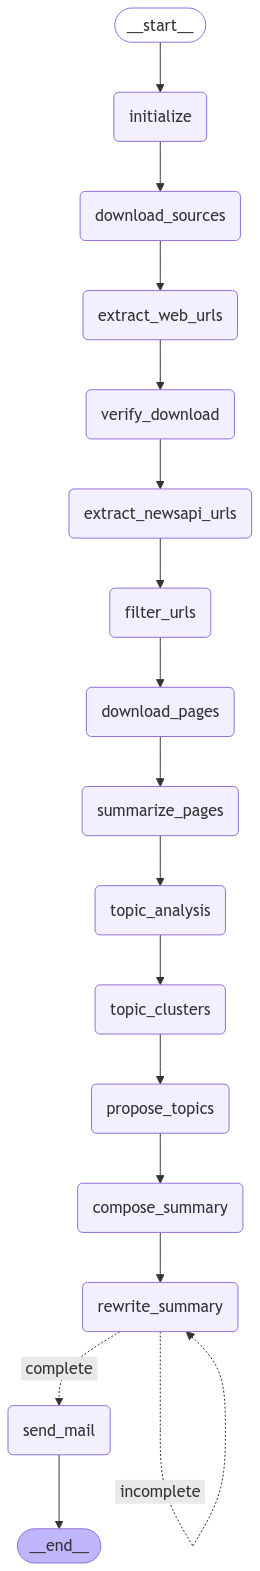

In [7]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-02-26 18:00'
do_download = False
ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
state, lg_agent, thread_id = initialize_agent(do_download, before_date, ml, mm, mh)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
state = lg_agent.initialize(state)


2025-02-27 12:20:49,764 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-02-27 12:20:49,765 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-02-27 12:20:49,766 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-02-27 12:20:49,766 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-02-27 12:20:49,767 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-02-27 12:20:49,767 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-02-27 12:20:49,767 - AInewsbot - INFO - 

In [6]:
state = lg_agent.download_sources(state)


2025-02-27 12:20:51,050 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-02-27 12:20:51,056 - AInewsbot - INFO - Found 16 previously downloaded files
2025-02-27 12:20:51,056 - AInewsbot - INFO - htmldata/Ars Technica (02_27_2025 11_58_28 AM).html
2025-02-27 12:20:51,057 - AInewsbot - INFO - htmldata/HackerNoon (02_27_2025 11_58_42 AM).html
2025-02-27 12:20:51,058 - AInewsbot - INFO - htmldata/Business Insider Tech (02_27_2025 11_58_27 AM).html
2025-02-27 12:20:51,059 - AInewsbot - INFO - htmldata/WSJ Technology (02_27_2025 11_59_20 AM).html
2025-02-27 12:20:51,059 - AInewsbot - INFO - htmldata/Feedly AI (02_27_2025 11_59_48 AM).html
2025-02-27 12:20:51,059 - AInewsbot - INFO - htmldata/The Register (02_27_2025 11_59_00 AM).html
2025-02-27 12:20:51,060 - AInewsbot - INFO - htmldata/Washington Post Technology (02_27_2025 11_59_25 AM).html
2025-02-27 12:20:51,060 - AInewsbot - INFO - htmldata/Techmeme (02_27_2025 11_58_53 AM).html
2025-02-27 12:20:51,061 - AI

In [ ]:
state = lg_agent.extract_web_urls(state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
state = lg_agent.verify_download(state)


In [ ]:
state = lg_agent.extract_newsapi_urls(state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
state = lg_agent.download_pages(state)


In [ ]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))


In [ ]:
z = pd.DataFrame(state["AIdf"])['summary'].to_list()
print(len([z for a in z if a]))
z

In [8]:
with open('my_dict.pkl', 'rb') as f:
    state = pickle.load(f)
#     pickle.dump(state, f)

In [9]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
state = lg_agent.topic_analysis(state, model_override='gpt-4o-mini')


2025-02-27 12:21:27,914 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-27 12:21:32,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:32,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:33,405 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:34,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:35,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:36,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:36,615 - AInewsbot - INFO - 116 free-form topics extracted
2025-02-27 12:21:36,617 - AInewsbot - INFO - Starting assig

2025-02-27 12:21:36,648 - AInewsbot - INFO - Canonical topic review
2025-02-27 12:21:36,648 - AInewsbot - INFO - Canonical topic venture capital
2025-02-27 12:21:36,649 - AInewsbot - INFO - Canonical topic brain-computer interfaces
2025-02-27 12:21:36,649 - AInewsbot - INFO - Canonical topic facial recognition
2025-02-27 12:21:36,649 - AInewsbot - INFO - Canonical topic finance
2025-02-27 12:21:36,649 - AInewsbot - INFO - Canonical topic generative ai
2025-02-27 12:21:36,650 - AInewsbot - INFO - Canonical topic products
2025-02-27 12:21:36,650 - AInewsbot - INFO - Canonical topic ipos
2025-02-27 12:21:36,650 - AInewsbot - INFO - Canonical topic food & drink
2025-02-27 12:21:36,651 - AInewsbot - INFO - Canonical topic nvidia
2025-02-27 12:21:36,651 - AInewsbot - INFO - Canonical topic stripe
2025-02-27 12:21:36,651 - AInewsbot - INFO - Canonical topic job automation
2025-02-27 12:21:36,651 - AInewsbot - INFO - Canonical topic semiconductor chips
2025-02-27 12:21:36,652 - AInewsbot - INF

2025-02-27 12:21:41,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,642 - httpx 

2025-02-27 12:21:41,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:41,994 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,004 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,031 - httpx 

2025-02-27 12:21:42,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,344 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,375 - httpx 

2025-02-27 12:21:42,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:42,689 - httpx 

2025-02-27 12:21:43,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,099 - httpx 

2025-02-27 12:21:43,451 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,488 - httpx 

2025-02-27 12:21:43,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,991 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:43,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,006 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,008 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,015 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,023 - httpx 

2025-02-27 12:21:44,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,511 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:44,597 - httpx 

2025-02-27 12:21:45,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:45,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:45,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:45,967 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:45,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:45,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:45,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:46,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:46,073 - httpx 

2025-02-27 12:21:51,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:51,432 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:51,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:51,743 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:51,779 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:51,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:52,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:52,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:21:53,166 - httpx 

In [10]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[1].title_topic_str))

11 Python Libraries Every AI Engineer Should Know (Topics: AI Engineering Tools, Data Analysis, Gen AI, Generative AI, Hugging Face, Jobs & Careers, Language Models, Model Interaction And Orchestration, OpenAI, Python Libraries For AI, Science, Transformers)

In [11]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].bullet))

['Your new best friend': Amazon unveils an AI-powered version of its famous voice assistant Alexa - Euronews](https://www.euronews.com/next/2025/02/27/your-new-best-friend-amazon-unveils-an-ai-powered-version-of-its-famous-voice-assistant-al)

Topics: AI-Powered Voice Assistant, Amazon Alexa, Chatbots, Cybersecurity, Eu Cybersecurity Recommendations, European Union, Gen AI, Generative AI, Governance, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Science, Speech Recognition & Synthesis, Virtual Assistants

* Amazon unveiled an AI-powered version of its voice assistant, Alexa.
* During a demonstration, the enhanced Alexa stated, "I’m not just an assistant, I’m your new best friend in the digital world."
* A European Parliament report recommends aligning the EU’s cybersecurity certification scheme with France's SecNumCloud to better protect sensitive data from non-European laws.



In [12]:
state = lg_agent.topic_clusters(state)


2025-02-27 12:22:28,263 - AInewsbot - INFO - Fetching embeddings for 116 headlines
2025-02-27 12:22:29,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-27 12:22:29,953 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2025-02-27 12:22:29,978 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-02-27 12:22:31,034 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-27 12:22:32,446 - AInewsbot - INFO - Cluster with DBSCAN
2025-02-27 12:22:32,471 - AInewsbot - INFO - Found 7 clusters


,title_topic_str
0,"Rebuilding Alexa: How Amazon is mixing models, agents and browser-use for smarter AI (Topics: AI Voice Assistants, Alexa, Amazon, Artificial General Intelligence, Books & Publishing, Chatbots, Gen AI, Generative AI, Language Models, Model Mixing, Multi-Agent Orchestration, Music, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Science, Speech Recognition & Synthesis, Virtual Assistants)"
1,"Amazon's Alexa finally got its generative AI upgrade (Topics: Alexa Plus Upgrade, Amazon Prime Subscription Benefits, Artificial General Intelligence, Chatbots, Code Assistants, Customer Service, Deals, Gen AI, Generative AI, Generative AI Features In Alexa, Hardware, Internet Of Things, Language Models, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Singularity, Snowflake, Speech Recognition & Synthesis, Streaming, Transformers, Virtual & Augmented Reality, Virtual Assistants)"
2,"Amazons subscription-based Alexa+ looks highly capableand questionable (Topics: AI Language Model Integration, Amazon Subscription Model, Artificial General Intelligence, Chatbots, Code Assistants, Customer Service, Deals, Economics, Enhanced Alexa Capabilities, Finance, Gen AI, Generative AI, Hardware, Internet Of Things, Jobs & Careers, Language Models, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Singularity, Snowflake, Speech Recognition & Synthesis, Stocks, Streaming, Transformers, Transportation, Travel, Virtual & Augmented Reality, Virtual Assistants)"
3,"'Your new best friend': Amazon unveils an AI-powered version of its famous voice assistant Alexa (Topics: AI-Powered Voice Assistant, Amazon Alexa, Chatbots, Cybersecurity, Eu Cybersecurity Recommendations, European Union, Gen AI, Generative AI, Governance, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Science, Speech Recognition & Synthesis, Virtual Assistants)"


2025-02-27 12:22:33,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:33,146 - AInewsbot - INFO - I dub this cluster: Amazon Alexa and Generative AI


,title_topic_str
4,"DeepSeek sparks a nationwide push in China to deploy its LLMs everywhere from hospitals to local governments, as Beijing seeks to solidify its gains in AI (Topics: AI Adoption, China, Deepfakes, Deepseek, Deepseek Competition, Deepseek Expansion In China, Gen AI, Generative AI, Governance, Government Support For AI, Healthcare, Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Public Sector AI, Science, State-Owned Enterprises)"
5,"DeepSeek spreads across China with Beijings backing (Topics: AI In Public Sector, Beijing Government Backing, China, Deepfakes, Deepseek, Deepseek Competition, Deepseek Growth, Gen AI, Generative AI, Governance, Healthcare, Healthcare Applications, Local Government Adoption, Policy And Regulation, Politics, Privacy & Surveillance, Products, Science)"
6,"Tencent Releases Turbo AI Model It Says Is Faster Than DeepSeek (Topics: AI Performance, China, Deepseek, Deepseek Competition, Tencent, Turbo AI Model)"
7,"Alibaba And DeepSeek Intensify AI Showdown, Challenge OpenAI Market Dominance (Topics: Alibaba AI Competition, Challenging OpenAI, China, Deepseek, Deepseek Competition, Economics, Gen AI, Generative AI, Open Source, OpenAI, Politics, Science, Stocks, Venture Capital)"


2025-02-27 12:22:33,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:33,827 - AInewsbot - INFO - I dub this cluster: AI Competition in China


,title_topic_str
8,"Nvidias Profit Jumps 80% as Company Rides Techs A.I. Boom (Topics: AI Chip Demand, Deepseek, Deepseek Competition, Economics, Finance, Gen AI, Generative AI, Hardware, Language Models, Market Value Fluctuations, Nvidia, Products, Profit Increase, Science, Semiconductor Chips, Stocks)"
9,"Nvidia stock slides as CFO raises worries over unknowns on Trump tariffs, export controls (Topics: China, Economics, Export Controls, Finance, Financial Uncertainty, Governance, Hardware, Legal Issues, Nvidia, Policy And Regulation, Politics, Products, Semiconductor Chips, Stock Decline, Stocks, Trump Tariffs Concerns)"
10,"Nvidia passes its quarterly future-shock stress test (Topics: Financial Challenges, Nvidia, Quarterly Stress Test)"
11,"Nvidia Stock Braces For AI Chipmaker's Fiscal Q4 Report (Live Coverage) (Topics: AI Revolution, Blackwell AI Processor, Economics, Finance, Gen AI, Generative AI, Hardware, Nvidia, Products, Quarterly Earnings, Revenue Projections, Science, Semiconductor Chips, Stocks)"
12,"Big bang Nvidia Q4 earnings today; here's what you need to watch out for (Topics: AI Infrastructure Demand, Blackwell Platform, China, Deepseek, Deepseek Competition, Economics, Finance, Financial Performance Predictions, Gen AI, Generative AI, Hardware, Infrastructure, Manufacturing, Nvidia, Nvidia Q4 Earnings, Products, Semiconductor Chips, Stocks)"
13,"Wall Street is anxiously watching Nvidia earnings again. What to know, by the numbers (Topics: AI Demand, Artificial General Intelligence, Economics, Finance, Gen AI, Generative AI, Hardware, Jobs & Careers, Language Models, Manufacturing, Nvidia, Nvidia Earnings Report, Products, Science, Semiconductor Chips, Semiconductor Industry, Singularity, Stocks)"
14,"Nvidia Reports Earnings After The Close (Topics: AI Chip Spending, Deals, Earnings Report, Economics, Finance, Gen AI, Generative AI, Investor Focus, Market Expectations, Nvidia, Policy And Regulation, Politics, Stocks)"
15,Nvidia Is Far From Running Out of Road (Topics: )


2025-02-27 12:22:34,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:34,647 - AInewsbot - INFO - I dub this cluster: Nvidia Financial Performance and Outlook


,title_topic_str
16,"Polish startup Nomagic, which makes robotic arms for logistics operations, raised a $44M Series B led by the EBRD, taking its total funding to ~$74M (Topics: AI-Powered Automation, Computer Vision, Data Analysis, Deals, Ebrd Investment, Economics, European Union, Finance, Funding, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Ipos, Job Automation, Jobs & Careers, Labor Market, Logistics Funding, Manufacturing, Nomagic, Policy And Regulation, Politics, Products, Robotics, Robots, Science, Seed Funding, Supply Chain Optimization, Transportation, Venture Capital)"
17,"Check out the pitch deck these ex-Googlers used to raise $3.25 million for their AI sales agent startup (Topics: AI Sales Agent, Breakout Startup, Chatbots, Code Assistants, Customer Interactions, Customer Service, Deals, Economics, Finance, Former Google Employees, Funding, Gen AI, Generative AI, Ipos, Job Automation, Jobs & Careers, Labor Market, Mergers And Acquisitions, Products, Seed Funding, Stocks, Venture Capital, Virtual Assistants)"
18,"Former Snowflake execs raise $5M for agentic AI that simplifies data operations (Topics: AI In Data Management, Cloud Data Operations, Data Analysis, Deals, Finance, Funding, Gen AI, Generative AI, Genesis Computing, Job Automation, Products, Science, Seed Funding, Snowflake, Venture Capital, Virtual Assistants)"
19,"Ethos raises $6M to enhance model risk management for financial institutions (Topics: Canapi Ventures, Cybersecurity, Data Analysis, Deals, Economics, Ethics, Ethos AI Funding, Finance, Financial Institutions, Fintech, Funding, Gen AI, Generative AI, Governance, Ipos, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Mergers And Acquisitions, Model Risk Management, Policy And Regulation, Products, Safety And Alignment, Science, Seed Funding, Stocks, Testing, Venture Capital)"


2025-02-27 12:22:35,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:35,765 - AInewsbot - INFO - I dub this cluster: AI Innovations in Funding and Automation


,title_topic_str
20,"Half of U.S. Workers Worry About How AI Will Affect Their Jobs (Topics: AI And Employment, AI Doom, AI Users, Emergent Misalignment, Ethics, Gen AI, Generative AI, Inequality, Job Automation, Job Market Impact, Jobs & Careers, Labor Market, Opinion, Pew Research, Safety And Alignment, Science, Society & Culture, Workplace Concerns About AI)"
21,"Hong Kong to cut thousands of civil service jobs, invest in AI to tackle rising deficit (Topics: AI Funding In Hong Kong, Artificial General Intelligence, China, Civil Service Job Cuts, Deals, Economics, Finance, Financial Strategy, Funding, Gen AI, Generative AI, Governance, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Paul Chan, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture, Tax Increase, Transportation, Travel)"
22,"Hong Kong to cut civil service jobs and invest in AI to tackle a rising deficit (Topics: AI Investment, Artificial General Intelligence, China, Deals, Economics, Finance, Financial Deficit, Funding, Gen AI, Generative AI, Governance, Hong Kong Civil Service Cuts, Inequality, Infrastructure, Infrastructure Projects, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture, Transportation, Travel)"


2025-02-27 12:22:36,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:36,286 - AInewsbot - INFO - I dub this cluster: Impact of AI on Employment


,title_topic_str
23,"How Nvidia Adapted Its Chips to Stay Ahead of an AI Industry Shift (Topics: Hardware, Nvidia, Semiconductor Chips)"
24,"Nvidia CEO: Someday well have 1B robotic cars on the road (Topics: AI Infrastructure Growth, Automotive Revenue, Autonomous Vehicles, Economics, Gen AI, Generative AI, Hardware, India, Infrastructure, Internet Of Things, Japan, Nvidia, Products, Robotic Cars Prediction, Robotics, Robots, Safety And Alignment, Science, Semiconductor Chips, Stocks, Sustainability, Toyota Partnership, Transportation)"
25,"Nvidia CEO Jensen Huang reinforces the company's role in the 'evolving' AI trade (Topics: AI Market Position, Chip Demand, Computing Power, Deepseek, Deepseek Competition, Economics, Finance, Gen AI, Generative AI, Hardware, Jensen Huang, Nvidia, Products, Science, Semiconductor Chips, Stocks)"


2025-02-27 12:22:37,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:37,058 - AInewsbot - INFO - I dub this cluster: Nvidia's Role in AI and Hardware


,title_topic_str
26,"Microsoft unveils the 3.8B-parameter text-only Phi-4-mini and 5.6B-parameter Phi-4-multimodal, claiming both outperform similar-sized models in certain tasks (Topics: Code Assistants, Complex Reasoning, Computer Vision, Gen AI, Generative AI, Hardware, Intellectual Property, Language Models, Microsoft, Microsoft Copilot, Multimodal Capabilities, Open Source, Open-Source Language Models, Phi-4 AI Models, Products, Science, Transformers)"
27,"Microsofts new Phi-4 AI models pack big performance in small packages (Topics: AI Deployment, Code Assistants, Computer Vision, Economics, Finance, Gen AI, Generative AI, Hardware, Hardware Efficiency, Hugging Face, Intellectual Property, Language Models, Microsoft, Microsoft Copilot, Mixture Of Loras, Phi-4 Models Performance, Privacy, Privacy & Surveillance, Products, Science, Speech Recognition & Synthesis, Transformers)"
28,"Qodos open code embedding model sets new enterprise standard, beating OpenAI, Salesforce (Topics: Artificial General Intelligence, Code Assistants, Code Embedding Model, Data Analysis, Gen AI, Generative AI, Hugging Face, Intellectual Property, Language Models, Nvidia, Open Source, OpenAI, Products, Programming Languages, Qodo, Review, Salesforce, Science, Testing)"


2025-02-27 12:22:37,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:37,951 - AInewsbot - INFO - I dub this cluster: Advancements in Generative AI Models
2025-02-27 12:22:38,025 - AInewsbot - INFO - Sending bullet points email
2025-02-27 12:22:39,217 - AInewsbot - INFO - ['Amazon Alexa and Generative AI', 'AI Competition in China', 'Nvidia Financial Performance and Outlook', 'AI Innovations in Funding and Automation', 'Impact of AI on Employment', "Nvidia's Role in AI and Hardware", 'Advancements in Generative AI Models']


In [13]:
state = lg_agent.propose_topics(state)


2025-02-27 12:22:39,250 - AInewsbot - INFO - Proposing categories using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-27 12:22:39,252 - AInewsbot - INFO - Initial cluster topics: 
Amazon Alexa and Generative AI
AI Competition in China
Nvidia Financial Performance and Outlook
AI Innovations in Funding and Automation
Impact of AI on Employment
Nvidia's Role in AI and Hardware
Advancements in Generative AI Models
2025-02-27 12:22:49,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:54,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:22:54,209 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Amazon Alexa and Generative AI
AI Competition in China
Nvidia Financial Performance and Outlook
AI Innovations in Funding and Automation
Impact of AI on Employment
Nvidia's Role in AI and Hardware
A

In [14]:
# compose using o3-mini and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete' or len(state["summary"])<5:
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)
display(Markdown(state["summary"].replace("$", "\\\\$")))


2025-02-27 12:23:34,831 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-27 12:23:57,508 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-27 12:23:57,514 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


# Alexa Ascension: Voice Assistant Amplitude
- Amazon is radically upgrading its Alexa voice assistant with "Alexa+," which mixes model orchestration, proactive AI agents, and web browsing to offer smarter, context-aware suggestions - [VentureBeat](https://venturebeat.com/ai/rebuilding-alexa-how-amazon-is-mixing-models-agents-and-browser-use-for-smarter-ai/).
- A generative AI upgrade dubbed Alexa Plus now enables shopping assistance, event invites, and personalized user memories, with free access for Prime members and a subscription option for others - [Quartz](https://qz.com/amazon-ai-alexa-plus-prime-virtual-assistant-1851766561).
- The subscription-based Alexa+ rollout, leveraging large language models from Amazon Bedrock and Anthropic, aims to revitalize the voice assistant business with advanced appointment and recommendation features - [Ars Technica](https://arstechnica.com/gadgets/2025/02/amazons-subscription-based-alexa-looks-highly-capable-and-questionable/).
- An AI-powered Alexa demonstration emphasized a friendlier, human-like digital presence, hinting at broader implications for user privacy and cybersecurity in Europe - [Euronews](https://www.euronews.com/next/2025/02/27/your-new-best-friend-amazon-unveils-an-ai-powered-version-of-its-famous-voice-assistant-al).

# Dragon’s Data Drive: China’s AI Charge
- DeepSeek is rapidly expanding across China with strong backing from government authorities, deploying its AI models in hospitals, state-owned enterprises, and local governments - [Twitter](https://t.co/kOnzWEE4ZT).
- The startup’s models are being widely adopted in public and private sectors, exemplifying China’s aggressive nationwide push for AI integration - [Financial Times](https://www.ft.com/content/5684fb1f-1a84-4542-8fe9-2fcae9653f87).
- DeepSeek recently resumed its core programming interface after a temporary suspension, intensifying competition with Alibaba to challenge OpenAI’s market dominance - [biztoc.com](https://biztoc.com/x/7f1199986d09d452).
- Chinese developers are accelerating the launch of DeepSeek R2, a new AI chatbot model with enhanced multilingual and coding capabilities designed to rival ChatGPT – [ubergizmo.com](https://www.ubergizmo.com/2025/02/china-accelerates-deepseek-r2/).

# Nvidia’s Chip Chat: Earnings, Predictions and Market Moves
- Nvidia’s profit surged by 80% and revenue jumped by 78% year-over-year, driven by robust demand for its AI chips even amid a \\$600 billion market value loss scare – [The New York Times](https://www.nytimes.com/2025/02/26/technology/nvidia-quarterly-earnings.html).
- Despite exceeding quarterly profit expectations, Nvidia’s stock slid over 4% on concerns surrounding potential tariffs and export controls on its chips – [New York Post](https://nypost.com/2025/02/27/business/nvidia-stock-slides-as-cfo-cites-unknowns-on-trump-tariffs-export-controls/).
- Nvidia beat Q4 targets, with record sales of its Blackwell AI processor and projections hinting at \\$43 billion in next-quarter revenue, showcasing its continued leadership in AI infrastructure – [Investor's Business Daily](https://www.investors.com/news/technology/nvidia-stock-nvda-fiscal-q4-2025-earnings/).
- In discussing the future of AI, CEO Jensen Huang highlighted the potential for 1 billion robotic cars and the increasing need for powerful inferencing chips, reinforcing Nvidia’s advantageous market position – [Yahoo Finance](https://finance.yahoo.com/news/nvidia-ceo-jensen-huang-reinforces-the-companys-role-in-the-evolving-ai-trade-161908182.html).

# Startup Sparks & Venture Waves: Funding Fuels AI Disruption
- Polish robotics startup Nomagic secured \\$44 million in Series B funding to develop off-the-shelf AI-powered robotic arms for logistics, driving a surge in annual recurring revenue and expansion plans into North America – [TechCrunch](https://techcrunch.com/2025/02/26/nomagic-picks-up-44m-for-its-ai-powered-robotic-arms/).
- Former Snowflake executives’ venture Genesis Computing raised \\$5 million to develop AI agents that simplify cloud data management, automating complex data pipelines and enabling non-technical user queries – [SiliconANGLE](https://siliconangle.com/2025/02/26/former-snowflake-execs-raise-5m-agentic-ai-simplifies-data-operations/).
- Model risk management startup Ethos AI raised \\$6 million in seed funding to help financial institutions deploy AI models with confidence by streamlining risk validation and reporting – [SiliconANGLE](https://siliconangle.com/2025/02/26/ethos-raises-6m-enhance-model-risk-management-financial-institutions/).
- Breakout, an AI sales agent startup led by former Google employees, secured \\$3.25 million in seed funding to handle early-stage customer interactions and personalized demos – [Business Insider](https://www.businessinsider.com/breakout-funding-ai-sales-agent-startup-google-pitch-deck-2025-2).
- Bridgetown Research combined AI-powered data analysis with management consulting, locking in \\$19 million in Series A funding to democratize strategic business advice for smaller companies – [Forbes](https://www.forbes.com/sites/davidprosser/2025/02/26/meet-the-ai-offering-cut-price-management-consultancy/).

# Model Marvels & Open-Source Breakthroughs
- Microsoft unveiled its new Phi-4 AI models—a 3.8B-parameter text-only and a 5.6B-parameter multimodal variant—that outperform similarly sized alternatives in complex reasoning and coding tasks – [SiliconANGLE](https://siliconangle.com/2025/02/26/microsoft-releases-new-phi-models-optimized-multimodal-processing-efficiency/).
- Qodo introduced Qodo-Embed-1-1.5B, an open-source code embedding model that excels in code search and retrieval, setting a new benchmark against rivals like OpenAI and Salesforce – [VentureBeat](https://venturebeat.com/programming-development/qodos-open-code-embedding-model-sets-new-enterprise-standard-beating-openai-salesforce/).
- IBM released the Granite 3.2 family of AI models, featuring switchable “chain of thought” reasoning and multimodal capabilities for tasks such as visual document understanding – [SiliconANGLE](https://siliconangle.com/2025/02/26/ibm-releases-new-granite-3-2-family-models-include-reasoning-want/).
- Hugging Face launched FastRTC, a new Python library that significantly simplifies development of real-time AI voice and video applications by automating complex WebRTC functionalities – [VentureBeat](https://venturebeat.com/ai/hugging-face-launches-fastrtc-to-simplify-real-time-ai-voice-and-video-apps/).
- ElevenLabs introduced Scribe v1, a speech-to-text model boasting 96.7% English accuracy and support for 99 languages, targeting enterprise transcription and accessibility use cases – [VentureBeat](https://venturebeat.com/ai/elevenlabs-new-speech-to-text-model-scribe-is-here-with-highest-accuracy-rate-so-far-96-7-for-english/).

# Ethics, Regulation & Social Reflections in the AI Era
- A recent Pew Research survey found that while only 16% of U.S. workers use AI in their jobs, 52% are concerned about its impact on future employment, reflecting widespread workplace anxiety – [Inc.](https://www.inc.com/kit-eaton/half-of-u-s-workers-worry-about-how-ai-will-affect-their-jobs/91152671).
- Skepticism persists as technical limitations, ethical concerns, and privacy issues in healthcare and creative industries fuel debate over AI’s broader societal impact – [Local News Matters](https://localnewsmatters.org/2025/02/26/not-everyone-is-keen-on-artificial-intelligence-heres-why-some-businesses-are-skeptical/).
- An AI-generated video by former President Trump depicting a redeveloped Gaza spurred widespread social media backlash and meme culture, igniting debates over disinformation and digital ethics – [The Economic Times](https://economictimes.indiatimes.com/news/international/us/donald-trumps-ai-video-of-gaza-features-elon-musk-skyscrapers-and-a-golden-statue-of-us-president/articleshow/118581642.cms).
- Critics warn that resorting to AI for emotional support might offer temporary relief but could impede genuine human connection and emotional processing – [The Walrus](https://thewalrus.ca/at-3-a-m-i-turned-to-ai-for-comfort-that-was-my-first-mistake/).
- Academics argue that current AI detection software, used to combat academic dishonesty, suffers from high false-positive rates, prompting calls for more authentic assessment methods – [Phys.org](https://phys.org/news/2025-02-ai-software-isnt-solution-classroom.html).

2025-02-27 12:23:57,518 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-27 12:24:22,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Daily Dispatch: Top Innovations, Investments, and Ethical Insights

## Alexa Ascension
- Amazon upgrades Alexa to "Alexa+" using models from Amazon Bedrock and Anthropic to offer context-aware suggestions, including shopping assistance, event invites, personalized memories, appointment scheduling, and web browsing; available free for Prime members or via subscription ([VentureBeat](https://venturebeat.com/ai/rebuilding-alexa-how-amazon-is-mixing-models-agents-and-browser-use-for-smarter-ai/), [Quartz](https://qz.com/amazon-ai-alexa-plus-prime-virtual-assistant-1851766561), [Ars Technica](https://arstechnica.com/gadgets/2025/02/amazons-subscription-based-alexa-looks-highly-capable-and-questionable/)).
- An AI-powered Alexa demo showcased a friendlier, human-like digital presence, raising questions on privacy and cybersecurity in Europe ([Euronews](https://www.euronews.com/next/2025/02/27/your-new-best-friend-amazon-unveils-an-ai-powered-version-of-its-famous-voice-assistant-al)).

## Dragon Data Drive
- DeepSeek expands in China with government backing, deploying AI models in hospitals, state-owned enterprises, local governments, and private sectors ([Twitter](https://t.co/kOnzWEE4ZT), [Financial Times](https://www.ft.com/content/5684fb1f-1a84-4542-8fe9-2fcae9653f87)).
- DeepSeek resumes its core programming interface after a temporary suspension, intensifying competition with Alibaba in challenging OpenAI ([biztoc.com](https://biztoc.com/x/7f1199986d09d452)).
- Chinese developers accelerate the launch of DeepSeek R2, a chatbot model with enhanced multilingual and coding capabilities ([ubergizmo.com](https://www.ubergizmo.com/2025/02/china-accelerates-deepseek-r2/)).

## Nvidia Chip Chat
- Nvidia posts an 80% profit surge and 78% revenue increase year-over-year, driven by robust AI chip demand amid market value concerns ([The New York Times](https://www.nytimes.com/2025/02/26/technology/nvidia-quarterly-earnings.html)).
- Despite exceeding expectations, Nvidia’s stock slid over 4% amid concerns over potential tariffs and export controls ([New York Post](https://nypost.com/2025/02/27/business/nvidia-stock-slides-as-cfo-cites-unknowns-on-trump-tariffs-export-controls/)).
- Nvidia beat Q4 targets with record Blackwell AI processor sales and projects \\$43 billion in next-quarter revenue ([Investor's Business Daily](https://www.investors.com/news/technology/nvidia-stock-nvda-fiscal-q4-2025-earnings/)).
- CEO Jensen Huang highlighted prospects for 1 billion robotic cars and increased demand for powerful inferencing chips ([Yahoo Finance](https://finance.yahoo.com/news/nvidia-ceo-jensen-huang-reinforces-the-companys-role-in-the-evolving-ai-trade-161908182.html)).

## Startup Sparks
- Nomagic secures \\$44M Series B for AI-powered robotic arms in logistics and expansion into North America ([TechCrunch](https://techcrunch.com/2025/02/26/nomagic-picks-up-44m-for-its-ai-powered-robotic-arms/)).
- Genesis Computing, founded by former Snowflake executives, raises \\$5M to develop AI agents that simplify cloud data management ([SiliconANGLE](https://siliconangle.com/2025/02/26/former-snowflake-execs-raise-5m-agentic-ai-simplifies-data-operations/)).
- Ethos AI raises \\$6M seed funding to help financial institutions deploy AI models with streamlined risk validation and reporting ([SiliconANGLE](https://siliconangle.com/2025/02/26/ethos-raises-6m-enhance-model-risk-management-financial-institutions/)).
- Breakout, an AI sales agent startup led by ex-Google employees, secures \\$3.25M seed funding for early-stage customer interactions and demos ([Business Insider](https://www.businessinsider.com/breakout-funding-ai-sales-agent-startup-google-pitch-deck-2025-2)).
- Bridgetown Research raises \\$19M Series A to combine AI-powered data analysis with management consulting for strategic business advice ([Forbes](https://www.forbes.com/sites/davidprosser/2025/02/26/meet-the-ai-offering-cut-price-management-consultancy/)).

## Model Marvels
- Microsoft introduces Phi-4 AI models—a 3.8B-parameter text-only and a 5.6B-parameter multimodal variant—designed for complex reasoning and coding tasks ([SiliconANGLE](https://siliconangle.com/2025/02/26/microsoft-releases-new-phi-models-optimized-multimodal-processing-efficiency/)).
- Qodo debuts Qodo-Embed-1-1.5B, an open-source code embedding model excelling in code search and retrieval ([VentureBeat](https://venturebeat.com/programming-development/qodos-open-code-embedding-model-sets-new-enterprise-standard-beating-openai-salesforce/)).
- IBM releases Granite 3.2 AI models featuring switchable chain-of-thought reasoning and multimodal capabilities for visual document understanding ([SiliconANGLE](https://siliconangle.com/2025/02/26/ibm-releases-new-granite-3-2-family-models-include-reasoning-want/)).
- Hugging Face launches FastRTC, a Python library to streamline real-time AI voice and video application development by automating WebRTC functionalities ([VentureBeat](https://venturebeat.com/ai/hugging-face-launches-fastrtc-to-simplify-real-time-ai-voice-and-video-apps/)).
- ElevenLabs debuts Scribe v1, a speech-to-text model with 96.7% English accuracy and support for 99 languages, aimed at enterprise transcription and accessibility ([VentureBeat](https://venturebeat.com/ai/elevenlabs-new-speech-to-text-model-scribe-is-here-with-highest-accuracy-rate-so-far-96-7-for-english/)).

## Ethical Echoes
- A Pew Research survey found that 16% of U.S. workers use AI while 52% worry about its impact on jobs; debates continue over AI’s technical limitations, ethics, and privacy in various industries ([Inc.](https://www.inc.com/kit-eaton/half-of-u-s-workers-worry-about-how-ai-will-affect-their-jobs/91152671), [Local News Matters](https://localnewsmatters.org/2025/02/26/not-everyone-is-keen-on-artificial-intelligence-heres-why-some-businesses-are-skeptical/)).
- An AI-generated video by former President Trump depicting a redeveloped Gaza sparks social media backlash and renews debates over disinformation and digital ethics ([The Economic Times](https://economictimes.indiatimes.com/news/international/us/donald-trumps-ai-video-of-gaza-features-elon-musk-skyscrapers-and-a-golden-statue-of-us-president/articleshow/118581642.cms)).
- Critics warn that using AI for emotional support may offer only temporary relief while potentially impeding genuine human connection ([The Walrus](https://thewalrus.ca/at-3-a-m-i-turned-to-ai-for-comfort-that-was-my-first-mistake/)).
- Academics call for improved assessment methods as current AI detection software yields high false-positive rates ([Phys.org](https://phys.org/news/2025-02-ai-software-isnt-solution-classroom.html)).

2025-02-27 12:24:22,586 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-27 12:24:45,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Daily Dispatch: Top Innovations, Investments, and Ethical Insights

## Alexa Ascends
- Amazon upgrades Alexa to "Alexa+" with models from Amazon Bedrock and Anthropic for context-aware suggestions including shopping, event invites, personalized memories, scheduling, and web browsing, available free for Prime members or via subscription ([VentureBeat](https://venturebeat.com/ai/rebuilding-alexa-how-amazon-is-mixing-models-agents-and-browser-use-for-smarter-ai/), [Quartz](https://qz.com/amazon-ai-alexa-plus-prime-virtual-assistant-1851766561), [Ars Technica](https://arstechnica.com/gadgets/2025/02/amazons-subscription-based-alexa-looks-highly-capable-and-questionable/)).
- An AI-powered Alexa demo showcased a more human-like digital presence, raising privacy and cybersecurity concerns in Europe ([Euronews](https://www.euronews.com/next/2025/02/27/your-new-best-friend-amazon-unveils-an-ai-powered-version-of-its-famous-voice-assistant-al)).

## DeepSeek Developments
- DeepSeek expands in China with government backing, deploying AI models in hospitals, state-owned enterprises, and local governments, while resuming its core programming interface and accelerating the launch of its R2 chatbot with enhanced multilingual and coding capabilities ([Twitter](https://t.co/kOnzWEE4ZT), [Financial Times](https://www.ft.com/content/5684fb1f-1a84-4542-8fe9-2fcae9653f87), [biztoc.com](https://biztoc.com/x/7f1199986d09d452), [ubergizmo.com](https://www.ubergizmo.com/2025/02/china-accelerates-deepseek-r2/)).

## Nvidia Chip Chat
- Nvidia posts an 80% profit surge and 78% revenue increase year-over-year driven by robust AI chip demand ([The New York Times](https://www.nytimes.com/2025/02/26/technology/nvidia-quarterly-earnings.html)).
- Despite exceeding expectations, Nvidia’s stock fell over 4% amid concerns over tariffs and export controls ([New York Post](https://nypost.com/2025/02/27/business/nvidia-stock-slides-as-cfo-cites-unknowns-on-trump-tariffs-export-controls/)).
- Nvidia beat Q4 targets with record Blackwell AI processor sales and projects \\$43 billion in next-quarter revenue ([Investor's Business Daily](https://www.investors.com/news/technology/nvidia-stock-nvda-fiscal-q4-2025-earnings/)).
- CEO Jensen Huang noted prospects for 1 billion robotic cars and increased demand for powerful inferencing chips ([Yahoo Finance](https://finance.yahoo.com/news/nvidia-ceo-jensen-huang-reinforces-the-companys-role-in-the-evolving-ai-trade-161908182.html)).

## Startup Sparks
- Nomagic secures \\$44M Series B for AI-powered robotic arms in logistics and expansion into North America ([TechCrunch](https://techcrunch.com/2025/02/26/nomagic-picks-up-44m-for-its-ai-powered-robotic-arms/)).
- Genesis Computing raises \\$5M to develop AI agents that simplify cloud data management, founded by former Snowflake executives ([SiliconANGLE](https://siliconangle.com/2025/02/26/former-snowflake-execs-raise-5m-agentic-ai-simplifies-data-operations/)).
- Ethos AI raises \\$6M seed funding to help financial institutions deploy AI models for risk validation and reporting ([SiliconANGLE](https://siliconangle.com/2025/02/26/ethos-raises-6m-enhance-model-risk-management-financial-institutions/)).
- Breakout, an AI sales agent startup led by ex-Google employees, secures \\$3.25M seed funding for early-stage customer demos ([Business Insider](https://www.businessinsider.com/breakout-funding-ai-sales-agent-startup-google-pitch-deck-2025-2)).
- Bridgetown Research raises \\$19M Series A to combine AI-powered data analysis with management consulting for strategic advice ([Forbes](https://www.forbes.com/sites/davidprosser/2025/02/26/meet-the-ai-offering-cut-price-management-consultancy/)).

## Model Marvels
- Microsoft introduces Phi-4 AI models—a 3.8B-parameter text-only and a 5.6B-parameter multimodal variant—for complex reasoning and coding tasks ([SiliconANGLE](https://siliconangle.com/2025/02/26/microsoft-releases-new-phi-models-optimized-multimodal-processing-efficiency/)).
- Qodo debuts Qodo-Embed-1-1.5B, an open-source code embedding model for code search and retrieval ([VentureBeat](https://venturebeat.com/programming-development/qodos-open-code-embedding-model-sets-new-enterprise-standard-beating-openai-salesforce/)).
- IBM releases Granite 3.2 AI models with switchable chain-of-thought reasoning and multimodal capabilities for visual document understanding ([SiliconANGLE](https://siliconangle.com/2025/02/26/ibm-releases-new-granite-3-2-family-models-include-reasoning-want/)).
- Hugging Face launches FastRTC, a Python library that automates WebRTC functionalities for real-time AI voice and video applications ([VentureBeat](https://venturebeat.com/ai/hugging-face-launches-fastrtc-to-simplify-real-time-ai-voice-and-video-apps/)).
- ElevenLabs debuts Scribe v1, a speech-to-text model with 96.7% English accuracy and support for 99 languages for enterprise transcription ([VentureBeat](https://venturebeat.com/ai/elevenlabs-new-speech-to-text-model-scribe-is-here-with-highest-accuracy-rate-so-far-96-7-for-english/)).

## Ethical Edge
- A Pew Research survey found 16% of U.S. workers use AI while 52% worry about its impact on jobs; debates continue over AI’s technical limitations, ethics, and privacy in various industries ([Inc.](https://www.inc.com/kit-eaton/half-of-u-s-workers-worry-about-how-ai-will-affect-their-jobs/91152671), [Local News Matters](https://localnewsmatters.org/2025/02/26/not-everyone-is-keen-on-artificial-intelligence-heres-why-some-businesses-are-skeptical/)).
- An AI-generated video by former President Trump depicting a redeveloped Gaza sparks social media backlash and raises disinformation concerns ([The Economic Times](https://economictimes.indiatimes.com/news/international/us/donald-trumps-ai-video-of-gaza-features-elon-musk-skyscrapers-and-a-golden-statue-of-us-president/articleshow/118581642.cms)).
- Critics warn that using AI for emotional support may offer only temporary relief while potentially impeding genuine human connection ([The Walrus](https://thewalrus.ca/at-3-a-m-i-turned-to-ai-for-comfort-that-was-my-first-mistake/)).
- Academics call for improved assessment methods as current AI detection software yields high false-positive rates ([Phys.org](https://phys.org/news/2025-02-ai-software-isnt-solution-classroom.html)).

2025-02-27 12:24:45,584 - AInewsbot - INFO - Sending summary email
2025-02-27 12:24:45,604 - AInewsbot - INFO - Email subject AI Daily Dispatch: Top Innovations, Investments, and Ethical Insights
2025-02-27 12:24:45,605 - AInewsbot - INFO - Email length 6864


# AI Daily Dispatch: Top Innovations, Investments, and Ethical Insights

## Alexa Ascends
- Amazon upgrades Alexa to "Alexa+" with models from Amazon Bedrock and Anthropic for context-aware suggestions including shopping, event invites, personalized memories, scheduling, and web browsing, available free for Prime members or via subscription ([VentureBeat](https://venturebeat.com/ai/rebuilding-alexa-how-amazon-is-mixing-models-agents-and-browser-use-for-smarter-ai/), [Quartz](https://qz.com/amazon-ai-alexa-plus-prime-virtual-assistant-1851766561), [Ars Technica](https://arstechnica.com/gadgets/2025/02/amazons-subscription-based-alexa-looks-highly-capable-and-questionable/)).
- An AI-powered Alexa demo showcased a more human-like digital presence, raising privacy and cybersecurity concerns in Europe ([Euronews](https://www.euronews.com/next/2025/02/27/your-new-best-friend-amazon-unveils-an-ai-powered-version-of-its-famous-voice-assistant-al)).

## DeepSeek Developments
- DeepSeek expands in China with government backing, deploying AI models in hospitals, state-owned enterprises, and local governments, while resuming its core programming interface and accelerating the launch of its R2 chatbot with enhanced multilingual and coding capabilities ([Twitter](https://t.co/kOnzWEE4ZT), [Financial Times](https://www.ft.com/content/5684fb1f-1a84-4542-8fe9-2fcae9653f87), [biztoc.com](https://biztoc.com/x/7f1199986d09d452), [ubergizmo.com](https://www.ubergizmo.com/2025/02/china-accelerates-deepseek-r2/)).

## Nvidia Chip Chat
- Nvidia posts an 80% profit surge and 78% revenue increase year-over-year driven by robust AI chip demand ([The New York Times](https://www.nytimes.com/2025/02/26/technology/nvidia-quarterly-earnings.html)).
- Despite exceeding expectations, Nvidia’s stock fell over 4% amid concerns over tariffs and export controls ([New York Post](https://nypost.com/2025/02/27/business/nvidia-stock-slides-as-cfo-cites-unknowns-on-trump-tariffs-export-controls/)).
- Nvidia beat Q4 targets with record Blackwell AI processor sales and projects \\$43 billion in next-quarter revenue ([Investor's Business Daily](https://www.investors.com/news/technology/nvidia-stock-nvda-fiscal-q4-2025-earnings/)).
- CEO Jensen Huang noted prospects for 1 billion robotic cars and increased demand for powerful inferencing chips ([Yahoo Finance](https://finance.yahoo.com/news/nvidia-ceo-jensen-huang-reinforces-the-companys-role-in-the-evolving-ai-trade-161908182.html)).

## Startup Sparks
- Nomagic secures \\$44M Series B for AI-powered robotic arms in logistics and expansion into North America ([TechCrunch](https://techcrunch.com/2025/02/26/nomagic-picks-up-44m-for-its-ai-powered-robotic-arms/)).
- Genesis Computing raises \\$5M to develop AI agents that simplify cloud data management, founded by former Snowflake executives ([SiliconANGLE](https://siliconangle.com/2025/02/26/former-snowflake-execs-raise-5m-agentic-ai-simplifies-data-operations/)).
- Ethos AI raises \\$6M seed funding to help financial institutions deploy AI models for risk validation and reporting ([SiliconANGLE](https://siliconangle.com/2025/02/26/ethos-raises-6m-enhance-model-risk-management-financial-institutions/)).
- Breakout, an AI sales agent startup led by ex-Google employees, secures \\$3.25M seed funding for early-stage customer demos ([Business Insider](https://www.businessinsider.com/breakout-funding-ai-sales-agent-startup-google-pitch-deck-2025-2)).
- Bridgetown Research raises \\$19M Series A to combine AI-powered data analysis with management consulting for strategic advice ([Forbes](https://www.forbes.com/sites/davidprosser/2025/02/26/meet-the-ai-offering-cut-price-management-consultancy/)).

## Model Marvels
- Microsoft introduces Phi-4 AI models—a 3.8B-parameter text-only and a 5.6B-parameter multimodal variant—for complex reasoning and coding tasks ([SiliconANGLE](https://siliconangle.com/2025/02/26/microsoft-releases-new-phi-models-optimized-multimodal-processing-efficiency/)).
- Qodo debuts Qodo-Embed-1-1.5B, an open-source code embedding model for code search and retrieval ([VentureBeat](https://venturebeat.com/programming-development/qodos-open-code-embedding-model-sets-new-enterprise-standard-beating-openai-salesforce/)).
- IBM releases Granite 3.2 AI models with switchable chain-of-thought reasoning and multimodal capabilities for visual document understanding ([SiliconANGLE](https://siliconangle.com/2025/02/26/ibm-releases-new-granite-3-2-family-models-include-reasoning-want/)).
- Hugging Face launches FastRTC, a Python library that automates WebRTC functionalities for real-time AI voice and video applications ([VentureBeat](https://venturebeat.com/ai/hugging-face-launches-fastrtc-to-simplify-real-time-ai-voice-and-video-apps/)).
- ElevenLabs debuts Scribe v1, a speech-to-text model with 96.7% English accuracy and support for 99 languages for enterprise transcription ([VentureBeat](https://venturebeat.com/ai/elevenlabs-new-speech-to-text-model-scribe-is-here-with-highest-accuracy-rate-so-far-96-7-for-english/)).

## Ethical Edge
- A Pew Research survey found 16% of U.S. workers use AI while 52% worry about its impact on jobs; debates continue over AI’s technical limitations, ethics, and privacy in various industries ([Inc.](https://www.inc.com/kit-eaton/half-of-u-s-workers-worry-about-how-ai-will-affect-their-jobs/91152671), [Local News Matters](https://localnewsmatters.org/2025/02/26/not-everyone-is-keen-on-artificial-intelligence-heres-why-some-businesses-are-skeptical/)).
- An AI-generated video by former President Trump depicting a redeveloped Gaza sparks social media backlash and raises disinformation concerns ([The Economic Times](https://economictimes.indiatimes.com/news/international/us/donald-trumps-ai-video-of-gaza-features-elon-musk-skyscrapers-and-a-golden-statue-of-us-president/articleshow/118581642.cms)).
- Critics warn that using AI for emotional support may offer only temporary relief while potentially impeding genuine human connection ([The Walrus](https://thewalrus.ca/at-3-a-m-i-turned-to-ai-for-comfort-that-was-my-first-mistake/)).
- Academics call for improved assessment methods as current AI detection software yields high false-positive rates ([Phys.org](https://phys.org/news/2025-02-ai-software-isnt-solution-classroom.html)).

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")